In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from functools import partial
from monai import data
from monai import transforms
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR, SegResNet, VNet, AttentionUnet
import os 
from matplotlib.colors import ListedColormap

/home/agata/Desktop/thesis_tumor_segmentation/.thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
root_dir = os.getcwd()
data_dir = root_dir + "/data/brats2021challenge"
results_dir = root_dir + "/results"
json_list = os.path.join(data_dir, "brats21_folds.json")
roi = (96, 96, 96)

In [4]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)


In [5]:
swinunetr_model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)

segresnet_model = SegResNet(
    blocks_down=[1, 2, 2, 4],   
    blocks_up=[1, 1, 1],       
    init_filters=16,        
    in_channels=4,         
    out_channels=3,          
    dropout_prob=0.2            
)

attunet_model = AttentionUnet(
    spatial_dims=3,  
    in_channels=4,   
    out_channels=3,  
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),             
    dropout=0.0                       
)


vnet_model = VNet(
    spatial_dims=3, 
    in_channels=4,   
    out_channels=3, 
    act=("elu", {"inplace": True})
)

monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


In [6]:
def get_segmentation(model, image, roi, test_loader=test_loader, overlap=0.6):
    model_inferer = partial(
        sliding_window_inference,
        roi_size=[roi[0], roi[1], roi[2]],
        sw_batch_size=1,
        predictor=model,
        overlap=overlap,
    )
    
    with torch.no_grad():
        for batch_data in test_loader:
            image = batch_data["image"].cuda()
            prob = torch.sigmoid(model_inferer(image))
            seg = prob[0].detach().cpu().numpy()
            seg = (seg > 0.5).astype(np.int8)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[1] == 1] = 2
            seg_out[seg[0] == 1] = 1
            seg_out[seg[2] == 1] = 4
    return seg_out


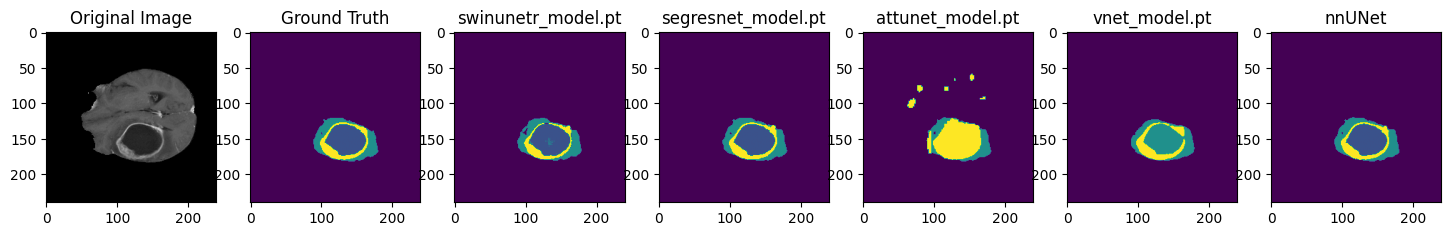

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    'swinunetr_model.pt': swinunetr_model,
    'segresnet_model.pt': segresnet_model,
    'attunet_model.pt': attunet_model,
    'vnet_model.pt': vnet_model
}

slice_num = 68
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz")
label_add = os.path.join(data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()

nnunet_segmentation_result = nib.load("/home/agata/Desktop/thesis_tumor_segmentation/models/nnUNet/nnUNet_results/Dataset101_BraTS2021/BraTS2021_01619.nii.gz").get_fdata()

fig, axs = plt.subplots(1, len(models) + 3, figsize=(18, 6))  
axs[0].imshow(img[:, :, slice_num], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(label[:, :, slice_num])
axs[1].set_title("Ground Truth")

for idx, (model_name, model) in enumerate(models.items()):
    try:
        model.load_state_dict(torch.load(os.path.join(results_dir, model_name))["state_dict"])
        model.to(device)
        model.eval()

        seg_out = get_segmentation(model, img, roi)
        
        axs[idx + 2].imshow(seg_out[:, :, slice_num])
        axs[idx + 2].set_title(f"{model_name}")
        
    except RuntimeError as e:
        print(f"{model_name} failed: {e}")
    finally:
        del model
        torch.cuda.empty_cache()

axs[len(models) + 2].imshow(nnunet_segmentation_result[:, :, slice_num])
axs[len(models) + 2].set_title("nnUNet")

plt.show()

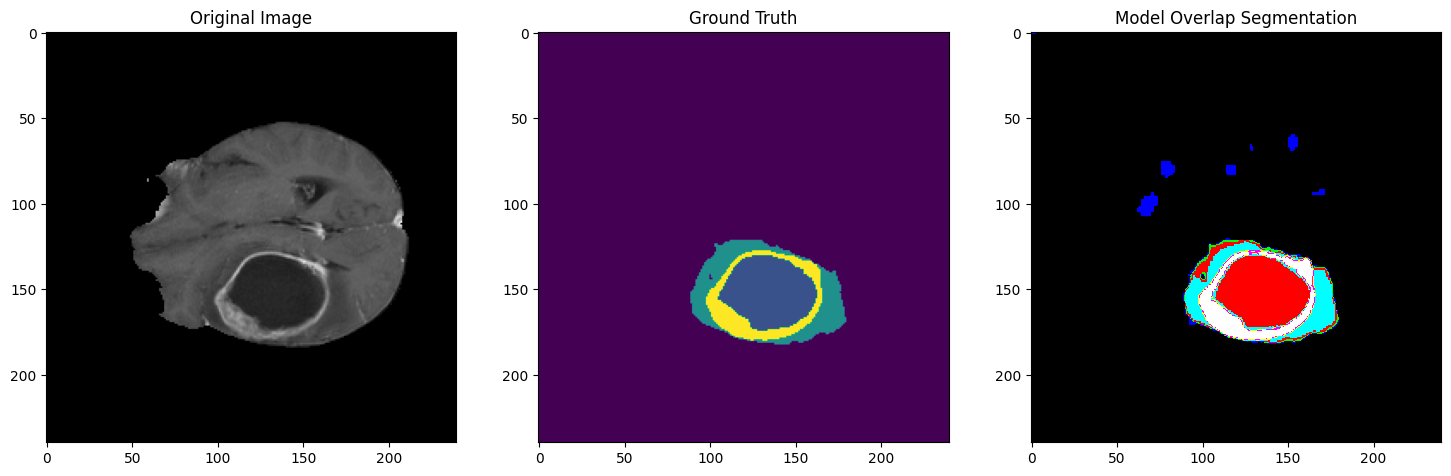

In [8]:
segmentations = {}
segmentations['nnUNet'] = nnunet_segmentation_result

for model_name, model in models.items():
    model.load_state_dict(torch.load(os.path.join(results_dir, model_name))["state_dict"])
    model.to(device)
    model.eval()
    
    seg_out = get_segmentation(model, img, roi)
    segmentations[model_name] = seg_out

overlap_seg = np.zeros_like(next(iter(segmentations.values())))

for model_name, seg in segmentations.items():
    overlap_seg += seg  

colors = [
    [0, 0, 0],          # Background - Black
    [0, 0, 1],          # Single prediction (blue)
    [0, 1, 0],          # Another single prediction (green)
    [1, 0, 0],          # Another single prediction (red)
    [0, 1, 1],          # Overlap of 2 models (cyan)
    [1, 1, 0],          # Overlap of 3 models (yellow)
    [1, 0, 1],          # Overlap of 4 models (magenta)
    [1, 1, 1],          # Overlap of all models (white)
]
cmap = ListedColormap(colors)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img[:, :, slice_num], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(label[:, :, slice_num])
axs[1].set_title("Ground Truth")

axs[2].imshow(overlap_seg[:, :, slice_num], cmap=cmap)
axs[2].set_title("Model Overlap Segmentation")

plt.show()

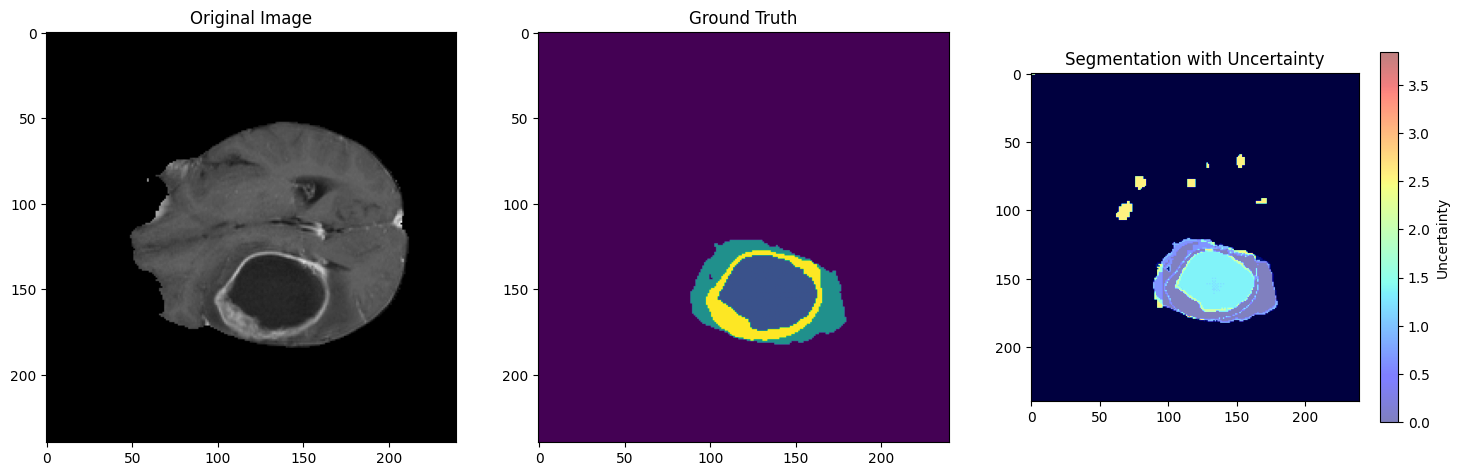

In [10]:
def get_ensemble_segmentation(models, image, roi, test_loader=test_loader, overlap=0.6):
    all_preds = []
    all_preds.append(nnunet_segmentation_result)

    for model in models.values():
        seg_out = get_segmentation(model, image, roi, test_loader, overlap)
        all_preds.append(seg_out)

    all_preds = np.array(all_preds)
    mean_preds = np.mean(all_preds, axis=0)
    uncertainty = np.var(all_preds, axis=0)
    final_segmentation = (mean_preds > 0.5).astype(np.int8)
    
    return final_segmentation, uncertainty


def get_ensemble_segmentation(models, image, roi, test_loader=test_loader, overlap=0.6):
    all_preds = []

    all_preds.append(nnunet_segmentation_result)
    
    for model in models.values():
        seg_out = get_segmentation(model, image, roi, test_loader, overlap)
        all_preds.append(seg_out)

    all_preds = np.array(all_preds)
    mean_preds = np.mean(all_preds, axis=0)
    uncertainty = np.var(all_preds, axis=0)
    final_segmentation = (mean_preds > 0.5).astype(np.int8)
    
    return final_segmentation, uncertainty


def plot_segmentation_with_uncertainty(img, label, segmentation, uncertainty_map, slice_num):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img[:, :, slice_num], cmap='gray')
    axes[0].set_title('Original Image')
    
    axes[1].imshow(label[:, :, slice_num])
    axes[1].set_title('Ground Truth')
    
    im = axes[2].imshow(segmentation[:, :, slice_num], cmap='gray')
    
    uncertainty_slice = uncertainty_map[:, :, slice_num]
    im_uncertainty = axes[2].imshow(uncertainty_slice, cmap='jet', alpha=0.5)  
    axes[2].set_title('Segmentation with Uncertainty')
    
    cbar = fig.colorbar(im_uncertainty, ax=axes[2], orientation='vertical', shrink=0.8)
    cbar.set_label('Uncertainty')  
    
    plt.show()

    
segmentation, uncertainty_map = get_ensemble_segmentation(models, img, roi)
plot_segmentation_with_uncertainty(img, label, segmentation, uncertainty_map, slice_num)